## **Import libary**

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage import feature


# **remapping the data so that it's ONLY 2 classes**

In [4]:
!mkdir -p /kaggle/working/train/fresh
!mkdir -p /kaggle/working/train/rotten
!mkdir -p /kaggle/working/test/fresh
!mkdir -p /kaggle/working/test/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshapples/* /kaggle/working/train/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshbanana/* /kaggle/working/train/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/freshoranges/* /kaggle/working/train/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenapples/* /kaggle/working/train/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenbanana/* /kaggle/working/train/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/train/rottenoranges/* /kaggle/working/train/rotten

In [5]:
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshapples/* /kaggle/working/test/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshbanana/* /kaggle/working/test/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/freshoranges/* /kaggle/working/test/fresh
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenapples/* /kaggle/working/test/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenbanana/* /kaggle/working/test/rotten
!cp -r /kaggle/input/fruits-fresh-and-rotten-for-classification/dataset/test/rottenoranges/* /kaggle/working/test/rotten

## **Loading Data**

In [2]:

def load_and_resize_images_from_folder(folder, target_size=(224, 224)):
    images = []
    labels = []
    for class_label in os.listdir(folder):
        class_path = os.path.join(folder, class_label)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                img_path = os.path.join(class_path, filename)
                img = cv2.imread(img_path,3)
                img = cv2.resize(img, target_size)  # Resize the image
                images.append(img)
                labels.append(class_label)
    return images, np.array(labels)

In [8]:
TRAIN_PATH = '/kaggle/working/train'
TEST_PATH = '/kaggle/working/test'

X_train_images, y_train = load_and_resize_images_from_folder(TRAIN_PATH)
X_test_images, y_test = load_and_resize_images_from_folder(TEST_PATH)

# **Visualization Dataset**

In [9]:
import random
#desplaying the train data
random_indices = random.sample(range(len(X_train_images)), 15)

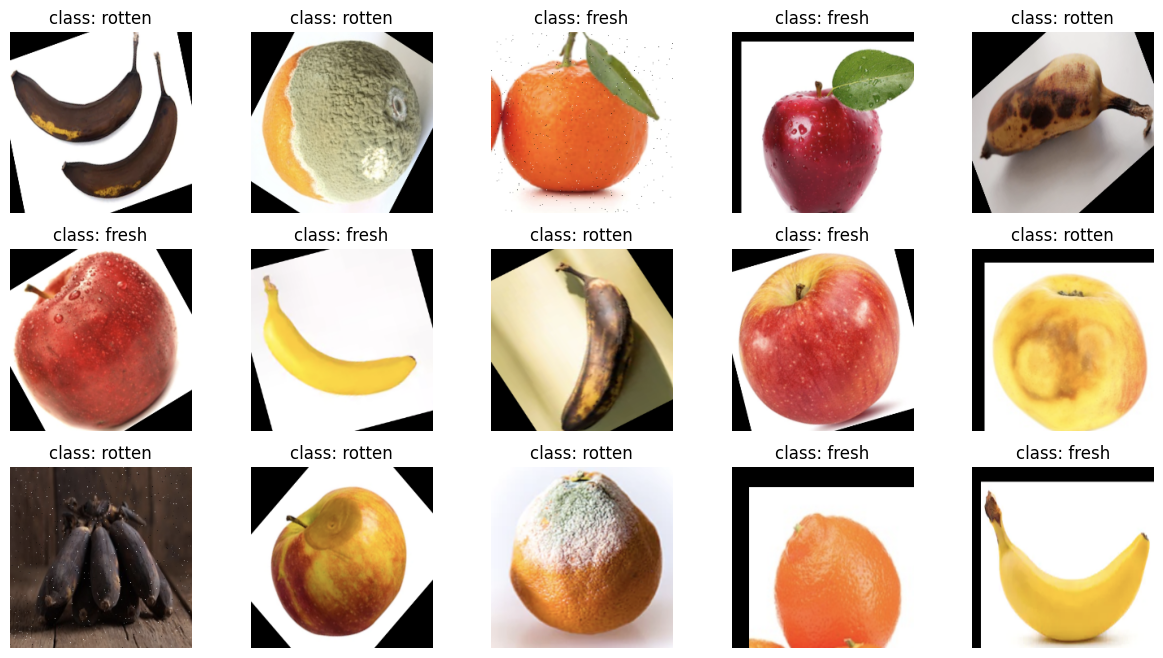

In [10]:
# Plot the images
plt.figure(figsize=(15, 8))
for i, index in enumerate(random_indices, 1):
    plt.subplot(3,5, i)
    plt.imshow(cv2.cvtColor(X_train_images[index], cv2.COLOR_BGR2RGB))
    plt.title(f'class: {y_train[index]}')
    plt.axis('off')

plt.show()

## **Convert Data to Features(USE HISTOGRAM)**

In [7]:
def compute_histogram_img(img_list, bins=(8, 8, 8)):
    img_features = []
    for img in img_list:
        # Convert Color to BGR
        bgr_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Calculate histogram color
        hist = cv2.calcHist([bgr_img], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
        # Normalize Histogram
        hist = cv2.normalize(hist, hist).flatten()
        img_features.append(hist)
    return np.array(img_features)



In [11]:
#Computer Features
X_train=compute_histogram_img(X_train_images)
X_test=compute_histogram_img(X_test_images)
y_train=np.where(y_train=='fresh',1,0)
y_test=np.where(y_test=='fresh',1,0)

In [12]:
# Split the training data into training and validation 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [13]:
print(X_train.shape) 
print(X_val.shape)
y_train


(7630, 512)
(3271, 512)


array([0, 0, 0, ..., 0, 1, 0])

## **Train SVM**

In [14]:
svm_classifier = SVC(C=0.1, kernel='poly', gamma=1)
svm_classifier.fit(X_train, y_train)

SVC(C=0.1, gamma=1, kernel='poly')

In [19]:
import joblib
save_path='/kaggle/working/svm_models.dat'
joblib.dump(svm_classifier,save_path )
print(f'Model saved : {save_path}')

Model saved : /kaggle/working/svm_models.dat


## **Evaluation**

### **1.Validation Set**

In [15]:
from collections import Counter
y_val_preds=[]
for i in X_val:
    y_val_pred=svm_classifier.predict(i.reshape(1,-1))
    y_val_preds.append(y_val_pred[0])
print(Counter(y_val_preds))

Counter({0: 1794, 1: 1477})


In [16]:
from sklearn.metrics import classification_report
print(f"Classification report for classifier {svm_classifier}:\n"
      f"{classification_report(y_val, y_val_preds)}")

Classification report for classifier SVC(C=0.1, gamma=1, kernel='poly'):
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1831
           1       0.90      0.93      0.91      1440

    accuracy                           0.92      3271
   macro avg       0.92      0.92      0.92      3271
weighted avg       0.92      0.92      0.92      3271



In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: "+str(accuracy_score(y_val, y_val_preds)))
print("Precision: "+str(precision_score(y_val, y_val_preds)))
print("Recall: "+str(recall_score(y_val, y_val_preds)))
print("F1-score: "+str(f1_score(y_val, y_val_preds)))

Accuracy: 0.9238764903699175
Precision: 0.903182125930941
Recall: 0.9263888888888889
F1-score: 0.9146383270483374


### **2.Test set**

In [17]:
y_test_preds=[]
for i in X_test:
    y_test_pred=svm_classifier.predict(i.reshape(1,-1))
    y_test_preds.append(y_test_pred[0])
print(Counter(y_test_preds))

Counter({0: 1495, 1: 1203})


In [18]:
from sklearn.metrics import classification_report
print(f"Classification report for classifier {svm_classifier}:\n"
      f"{classification_report(y_test, y_test_preds)}")

Classification report for classifier SVC(C=0.1, gamma=1, kernel='poly'):
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      1534
           1       0.90      0.93      0.92      1164

    accuracy                           0.93      2698
   macro avg       0.92      0.93      0.93      2698
weighted avg       0.93      0.93      0.93      2698



In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: "+str(accuracy_score(y_test, y_test_preds)))
print("Precision: "+str(precision_score(y_test, y_test_preds)))
print("Recall: "+str(recall_score(y_test, y_test_preds)))
print("F1-score: "+str(f1_score(y_test, y_test_preds)))

Accuracy: 0.9269829503335805
Precision: 0.9019118869492935
Recall: 0.9321305841924399
F1-score: 0.9167722855935785


## Test Image From Internet

In [32]:
image_paths='/kaggle/input/randomfruitfrominternet'
name_fruits=os.listdir(image_paths)
name_fruits

['rottenbanana.jpg', 'freshapple.jpg', 'orange.png', 'rottenapple.jpg']

In [33]:
def classify_image(image_path,model_path):
  image = cv2.imread(image_path)
  image = cv2.resize(image,(224,224))
  image_feature=compute_hog_img([image])
  model = joblib.load(model_path)
  pred = model.predict(image_feature.reshape(1,-1))

  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title(f'Predict:{pred}')
  plt.axis('off')
  plt.show()
  return pred


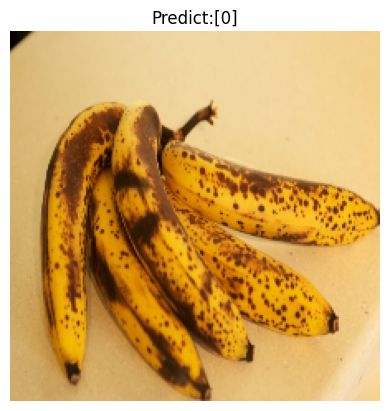

array([0])

In [37]:
fruits_path=[os.path.join(image_paths,i) for i in name_fruits]
model_path='/kaggle/working/svm_models.dat'
classify_image(fruits_path[0],model_path)

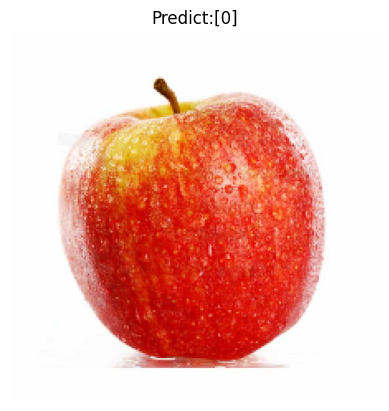

array([0])

In [40]:
#Predict is uncorrect maybe the image is not real.The photo is edited its color before uploading it online
fruits_path=[os.path.join(image_paths,i) for i in name_fruits]
model_path='/kaggle/working/svm_models.dat'
classify_image(fruits_path[1],model_path)

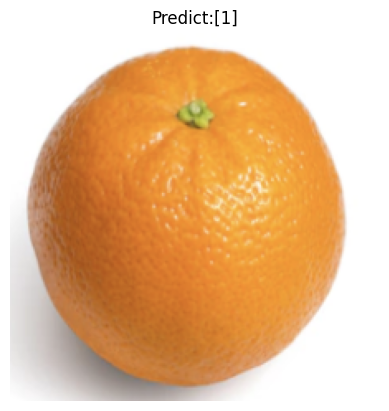

array([1])

In [39]:
fruits_path=[os.path.join(image_paths,i) for i in name_fruits]
model_path='/kaggle/working/svm_models.dat'
classify_image(fruits_path[2],model_path)

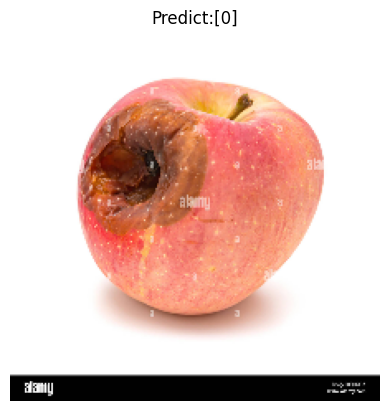

array([0])

In [36]:
fruits_path=[os.path.join(image_paths,i) for i in name_fruits]
model_path='/kaggle/working/svm_models.dat'
classify_image(fruits_path[3],model_path)